In [35]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import causal_convolution_layer
import Dataloader

In [36]:
import math
from torch.utils.data import DataLoader

In [37]:
def mean_absolute_percentage_error(y_true, y_pred):
    return torch.mean(torch.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

In [38]:
class TransformerTimeSeries(torch.nn.Module):
    """
    Time Series application of transformers based on paper
    
    causal_convolution_layer parameters:
        in_channels: the number of features per time point
        out_channels: the number of features outputted per time point
        kernel_size: k is the width of the 1-D sliding kernel
        
    nn.Transformer parameters:
        d_model: the size of the embedding vector (input)
    
    PositionalEncoding parameters:
        d_model: the size of the embedding vector (positional vector)
        dropout: the dropout to be used on the sum of positional+embedding vector
    
    """
    def __init__(self):
        super(TransformerTimeSeries,self).__init__()
        self.input_embedding = causal_convolution_layer.context_embedding(in_channels=2,embedding_size=64,k=5) # Gebruik de causal convolution layer uit causal_convolution_layer.py
        self.positional_embedding = torch.nn.Embedding(512,64) # Gebruik de standaard embedding layer van PyTorch voor de positional encoding (er is geen reden om de causal convolution layer hier te gebruiken, omdat de positional encoding niet causaal is)

        
        self.decode_layer = torch.nn.TransformerEncoderLayer(d_model=64,nhead=8, dim_feedforward=1024) # Gebruik de standaard transformer encoder laag. De d_model is 256, wat overeenkomt met de grootte van de embedding vector. nhead is 8, wat betekent dat er 8 heads (multi-head attention) worden gebruikt.
        self.transformer_decoder = torch.nn.TransformerEncoder(self.decode_layer, num_layers=3) # Gebruik de standaard transformer encoder. De transformer decoder bestaat uit 3 transformer encoder layers, die in de regel erboven worden gedefinieerd.
        
        self.fc1 = torch.nn.Linear(64,1) # Gebruik een lineaire laag om de output van de transformer naar een enkele waarde te transformeren.
        
    def forward(self,x,y,attention_masks):
        
        # concatenate observed points and time covariate
        # (B*feature_size*n_time_points)
        z = torch.cat((y.unsqueeze(1),x.unsqueeze(1)),1) # Z is een tensor waarin de time covariate en de observed points worden samengevoegd. Bijvoorbeeld als x een tensor is van grootte (B,n_time_points) en y een tensor is van grootte (B,n_time_points), dan is z een tensor van grootte (B,2,n_time_points).

        # input_embedding returns shape (Batch size,embedding size,sequence len) -> need (sequence len,Batch size,embedding_size)
        z_embedding = self.input_embedding(z).permute(2,0,1) # We passen de input_embedding toe op z en transponeren de dimensies zodat de dimensievolgorde (sequence len,Batch size,embedding_size) is.
        
        # get my positional embeddings (Batch size, sequence_len, embedding_size) -> need (sequence len,Batch size,embedding_size)
        positional_embeddings = self.positional_embedding(x.type(torch.long)).permute(1,0,2) # We passen de positional_embedding toe op x en transponeren de dimensies zodat de dimensievolgorde (sequence len,Batch size,embedding_size) is.
        
        input_embedding = z_embedding+positional_embeddings # We tellen de input_embedding en de positional_embeddings bij elkaar op.
        
        transformer_embedding = self.transformer_decoder(input_embedding,attention_masks) # We passen de transformer_decoder toe op de input_embedding en de attention_masks.

        output = self.fc1(transformer_embedding.permute(1,0,2)) # We passen de lineaire laag toe op de transformer_embedding en transponeren de dimensies zodat de dimensievolgorde (Batch size,sequence len,1) is.
        
        return output
        

In [39]:
t0 = 116 # t0 is de tijd vanaf waar we gaan voorspellen

In [40]:
# train_dataset = Dataloader.time_series_decoder_missing_paper(t0,4500) # missing
# validation_dataset = Dataloader.time_series_decoder_missing_paper(t0,500) # missing 
# test_dataset = Dataloader.time_series_decoder_missing_paper(t0,1000) # missing

train_dataset = Dataloader.time_series_decoder_paper(t0,4500) # Laad de train_dataset. t0 is de tijd vanaf waar we gaan voorspellen en 4500 is het aantal samples in de dataset (24 is een van de samples).
validation_dataset = Dataloader.time_series_decoder_paper(t0,500)
test_dataset = Dataloader.time_series_decoder_paper(t0,1000)

x: 4500*140 fx: 4500*140
x: 500*140 fx: 500*140
x: 1000*140 fx: 1000*140


In [41]:
criterion = torch.nn.MSELoss() # We gebruiken Mean Squared Error als loss functie.

In [42]:
train_dl = DataLoader(train_dataset,batch_size=32,shuffle=True) # We maken een DataLoader voor de dataset
validation_dl = DataLoader(validation_dataset,batch_size=64)
test_dl = DataLoader(test_dataset,batch_size=128)

In [43]:
model = TransformerTimeSeries().cuda() # We initialiseren het model en zetten het op de GPU.

In [44]:
lr = .0005 # learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
epochs = 300

In [45]:
def Dp(y_pred,y_true,q): # p-quantile loss helper function
    return max([q*(y_pred-y_true),(q-1)*(y_pred-y_true)])


In [46]:
def Rp_num_den(y_preds,y_trues,q): # p-quantile loss helper function 2
    numerator = np.sum([Dp(y_pred,y_true,q) for y_pred,y_true in zip(y_preds,y_trues)])
    denominator = np.sum([np.abs(y_true) for y_true in y_trues])
    return numerator,denominator

In [47]:
def train_epoch(model,train_dl,t0=96):
    model.train()
    train_loss = 0
    train_mape = 0
    n = 0
    for step,(x,y,attention_masks) in enumerate(train_dl):
        optimizer.zero_grad()
        output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())

        preds = output.squeeze()[:,(t0-1):(t0+24-1)]
        targets =y.cuda()[:,t0:]

        loss = criterion(preds,targets) # not missing data
        # loss = criterion(output.squeeze()[:,(t0-1-10):(t0+24-1-10)],y.cuda()[:,(t0-10):]) # missing data
        loss.backward()
        optimizer.step()
        
        train_loss += (loss.detach().cpu().item() * x.shape[0])
        train_mape += mean_absolute_percentage_error(targets.detach().cpu(), preds.detach().cpu()).item() * x.shape[0]
        n += x.shape[0]
    return train_loss/n, train_mape/n # return the average loss 

In [48]:
def eval_epoch(model,validation_dl,t0=96):
    model.eval()
    eval_loss = 0
    eval_mape = 0
    n = 0
    with torch.no_grad():
        for step,(x,y,attention_masks) in enumerate(validation_dl):
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())

            preds = output.squeeze()[:,(t0-1):(t0+24-1)]
            targets = y.cuda()[:,t0:]

            loss = criterion(preds, targets) # not missing data
            # loss = criterion(output.squeeze()[:,(t0-1-10):(t0+24-1-10)],y.cuda()[:,(t0-10):]) # missing data
            
            eval_loss += (loss.detach().cpu().item() * x.shape[0])
            eval_mape += mean_absolute_percentage_error(targets.detach().cpu(), preds.detach().cpu()).item() * x.shape[0]

            n += x.shape[0]
            
    return eval_loss/n, eval_mape/n # return the average loss

In [49]:
def test_epoch(model,test_dl,t0=96):
    with torch.no_grad():
        predictions = []
        observations = []

        model.eval()
        for step,(x,y,attention_masks) in enumerate(test_dl):
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())

            for p,o in zip(output.squeeze()[:,(t0-1):(t0+24-1)].cpu().numpy().tolist(),y.cuda()[:,t0:].cpu().numpy().tolist()): # not missing data
            #for p,o in zip(output.squeeze()[:,(t0-1-10):(t0+24-1-10)].cpu().numpy().tolist(),y.cuda()[:,(t0-10):].cpu().numpy().tolist()): # missing data


                predictions.append(p)
                observations.append(o)

        num = 0
        den = 0
        for y_preds,y_trues in zip(predictions,observations):
            num_i,den_i = Rp_num_den(y_preds,y_trues,.5) # we gebruiken p-quintile loss voor het evalueren van de performance (terwijl MSE tijdens training wordt gebruikt)
            num+=num_i
            den+=den_i
        Rp = (2*num)/den
        
    return Rp

In [50]:
train_epoch_loss = []
eval_epoch_loss = []
train_epoch_mape = []
eval_epoch_mape = []

Rp_best = 10
for e,epoch in enumerate(range(epochs)):
    train_loss = []
    eval_loss = []
    train_mape = []
    eval_mape = []

    
    l_t, l_t_mape = train_epoch(model,train_dl,t0)
    train_loss.append(l_t)
    train_mape.append(l_t_mape)
    
    l_e, l_e_mape = eval_epoch(model,validation_dl,t0)
    eval_loss.append(l_e)
    eval_mape.append(l_e_mape)
    
    Rp = test_epoch(model,test_dl,t0)

    if Rp_best > Rp:
        Rp_best = Rp
        
    train_epoch_loss.append(np.mean(train_loss))
    eval_epoch_loss.append(np.mean(eval_loss))
    
    print(f"Epoch {e}: Train loss: {np.mean(train_loss):.4f} \t Val loss: {np.mean(eval_loss):.4f} \t "
      f"Train MAPE: {np.mean(train_mape):.2f}% \t Val MAPE: {np.mean(eval_mape):.2f}% \t R_p = {Rp:.4f}")


Epoch 0: Train loss: 4928.9659 	 Val loss: 4468.5071 	 Train MAPE: 88.37% 	 Val MAPE: 83.03% 	 R_p = 0.8576
Epoch 1: Train loss: 4051.2292 	 Val loss: 3519.5804 	 Train MAPE: 76.46% 	 Val MAPE: 69.75% 	 R_p = 0.7440
Epoch 2: Train loss: 3083.7111 	 Val loss: 2571.7132 	 Train MAPE: 62.68% 	 Val MAPE: 56.14% 	 R_p = 0.6150
Epoch 3: Train loss: 2200.7401 	 Val loss: 1777.1485 	 Train MAPE: 50.30% 	 Val MAPE: 44.96% 	 R_p = 0.4924
Epoch 4: Train loss: 1517.6651 	 Val loss: 1215.7672 	 Train MAPE: 41.82% 	 Val MAPE: 38.42% 	 R_p = 0.3984
Epoch 5: Train loss: 1074.6971 	 Val loss: 887.8190 	 Train MAPE: 38.18% 	 Val MAPE: 36.28% 	 R_p = 0.3407
Epoch 6: Train loss: 693.2257 	 Val loss: 493.0609 	 Train MAPE: 23.81% 	 Val MAPE: 16.06% 	 R_p = 0.2082
Epoch 7: Train loss: 413.8180 	 Val loss: 302.1821 	 Train MAPE: 14.50% 	 Val MAPE: 11.35% 	 R_p = 0.1497
Epoch 8: Train loss: 260.2825 	 Val loss: 190.5202 	 Train MAPE: 10.79% 	 Val MAPE: 8.27% 	 R_p = 0.1105
Epoch 9: Train loss: 167.9666 	 Val 

In [59]:
print("Rp best={}".format(Rp_best))

# Evaluate the model on the test set
model.eval()
predictions = []
observations = []

with torch.no_grad():
    for step,(x,y,attention_masks) in enumerate(test_dl):
        output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())

        for p,o in zip(output.squeeze()[:,(t0-1):(t0+24-1)].cpu().numpy().tolist(),y.cuda()[:,t0:].cpu().numpy().tolist()): # not missing data
        #for p,o in zip(output.squeeze()[:,(t0-1-10):(t0+24-1-10)].cpu().numpy().tolist(),y.cuda()[:,(t0-10):].cpu().numpy().tolist()): # missing data

            predictions.append(p)
            observations.append(o)

# Print the MSE and MAPE
mse = np.mean((np.array(predictions) - np.array(observations))**2)
mape = np.mean(np.abs((np.array(predictions) - np.array(observations)) / (np.array(observations) + 1e-8))) * 100
print(f"Test MSE: {mse:.4f} \t Test MAPE: {mape:.3f}%")

Rp best=0.011654943236995816
Test MSE: 1.1119 	 Test MAPE: 1.403%


## Visualize the data

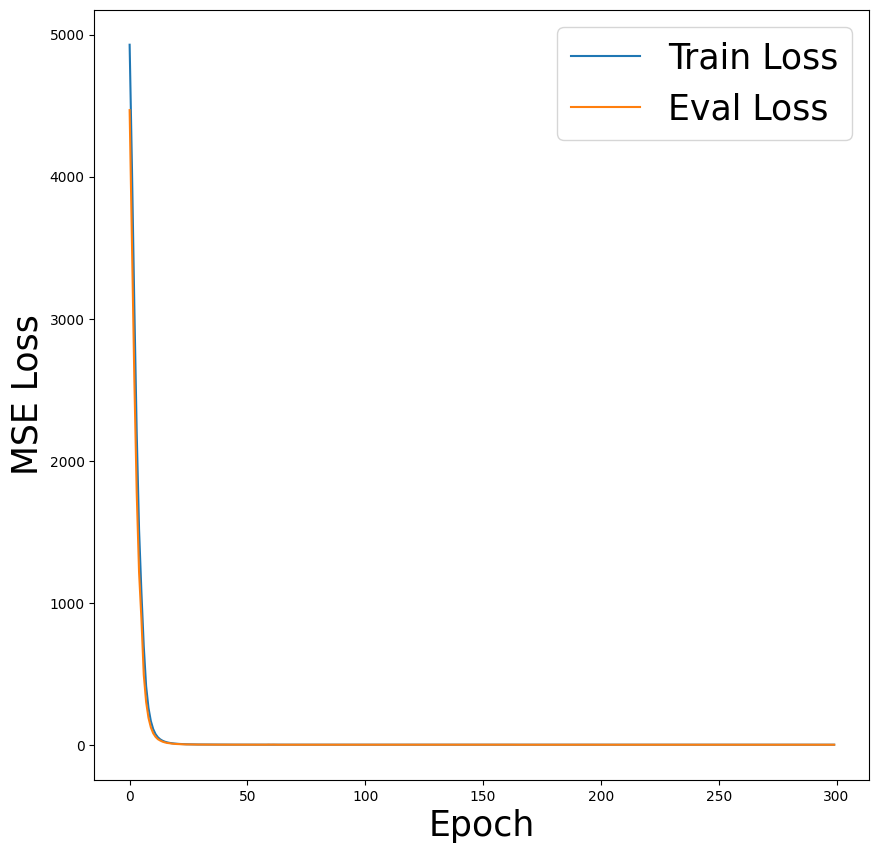

In [52]:
plt.figure(figsize=(10,10))
plt.plot(train_epoch_loss)
plt.plot(eval_epoch_loss)
plt.legend(['Train Loss','Eval Loss'],fontsize=25)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("MSE Loss",fontsize=25)
plt.show()

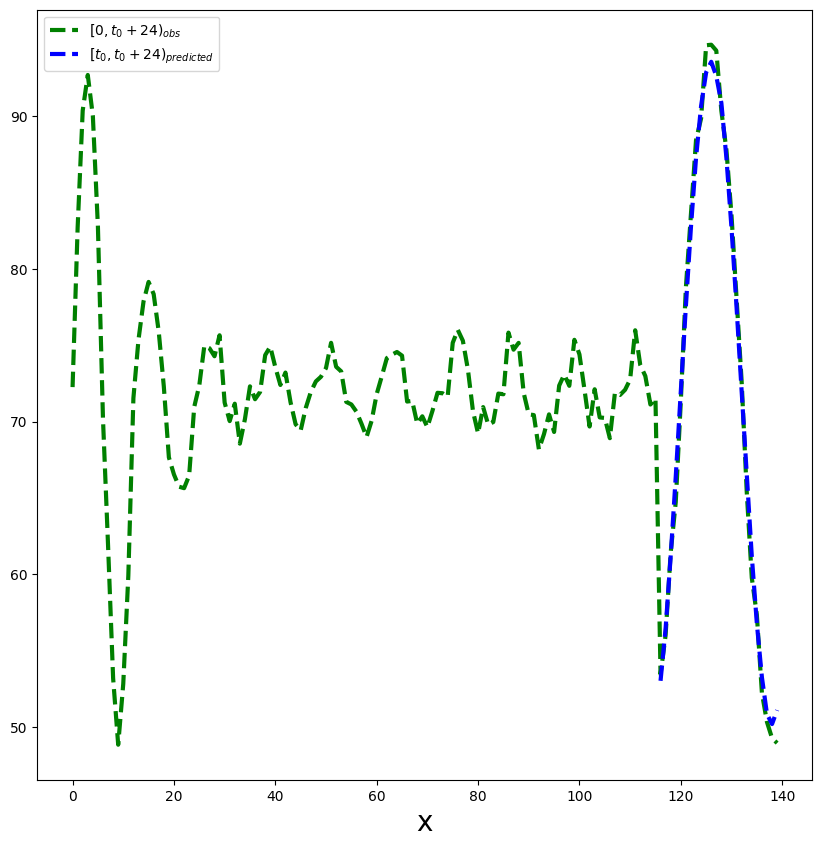

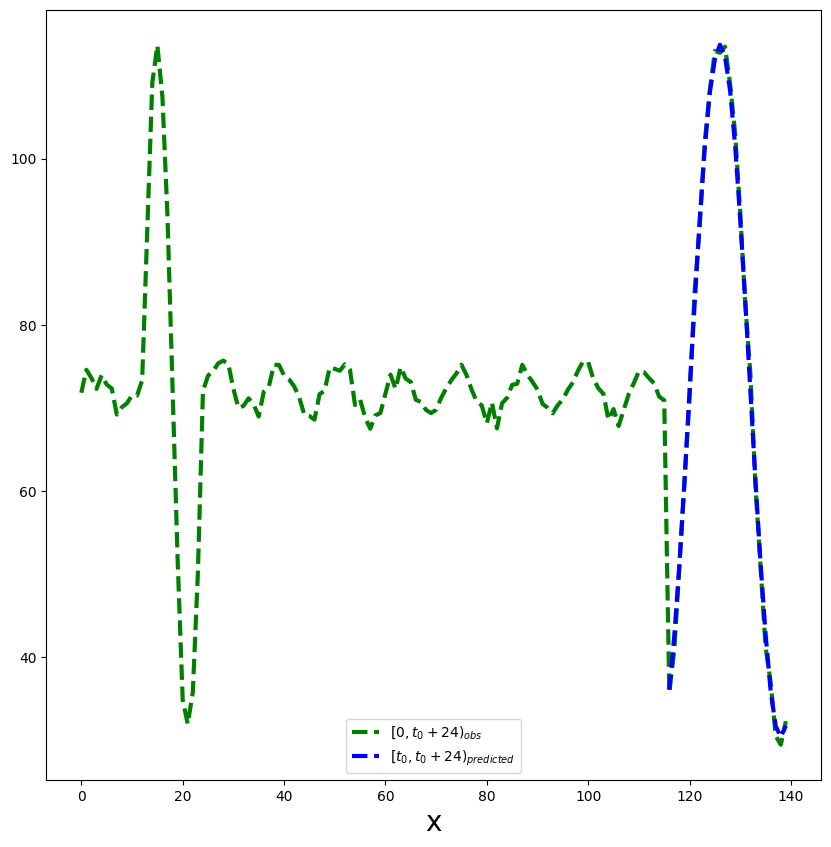

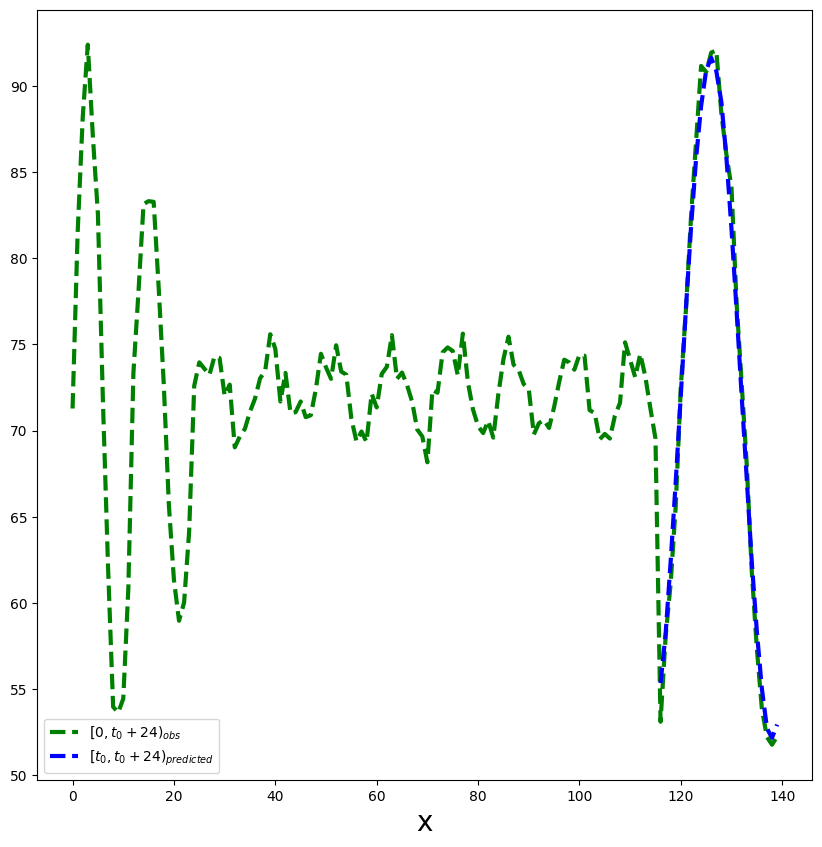

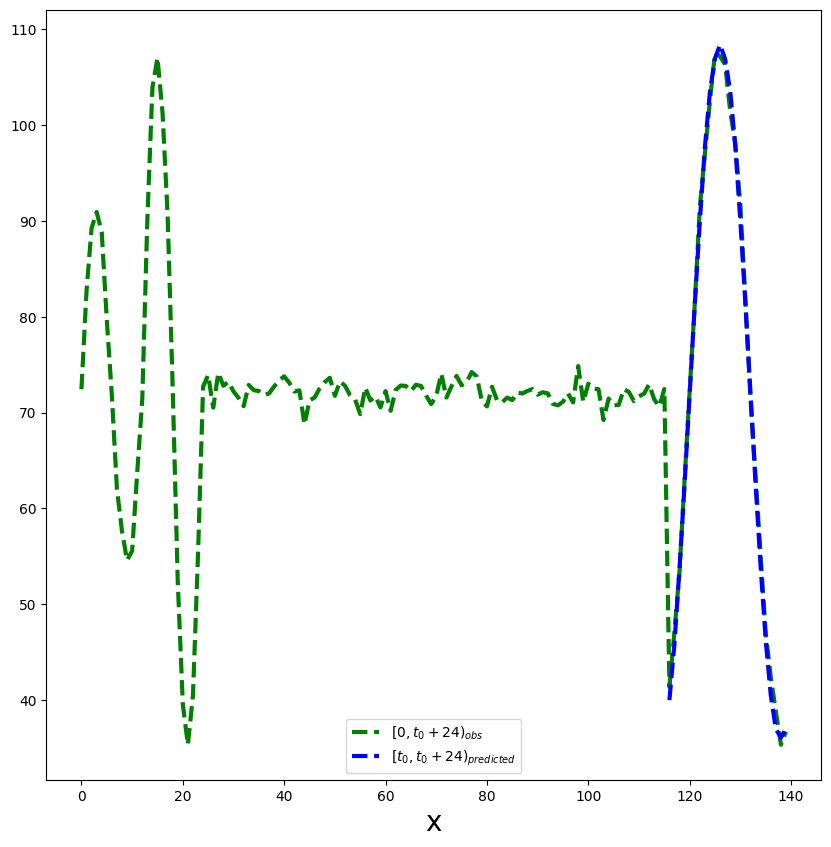

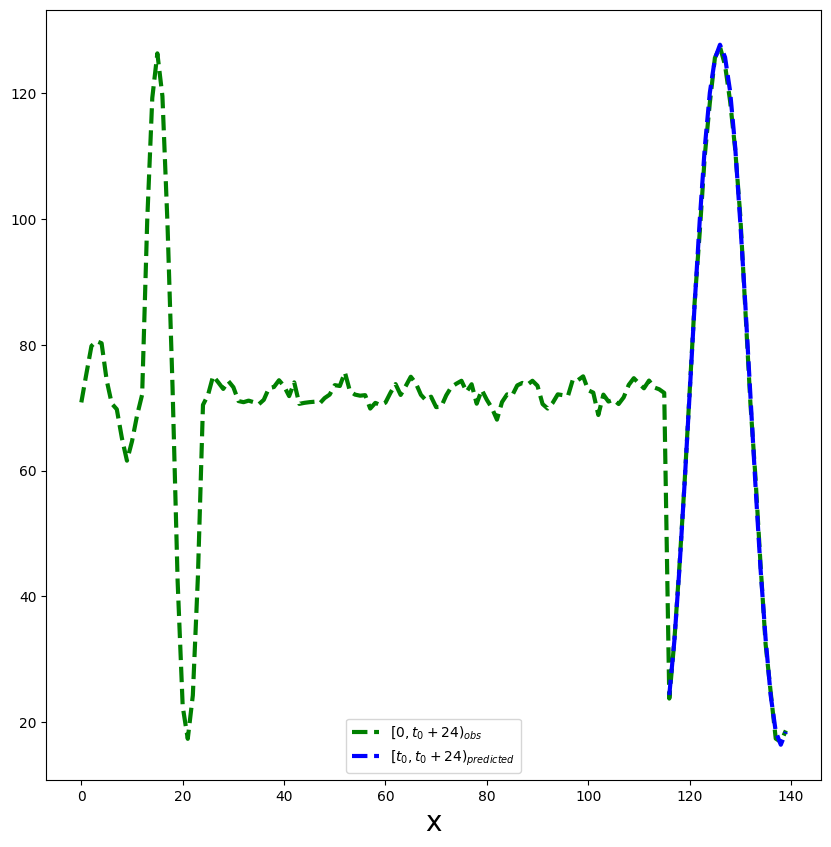

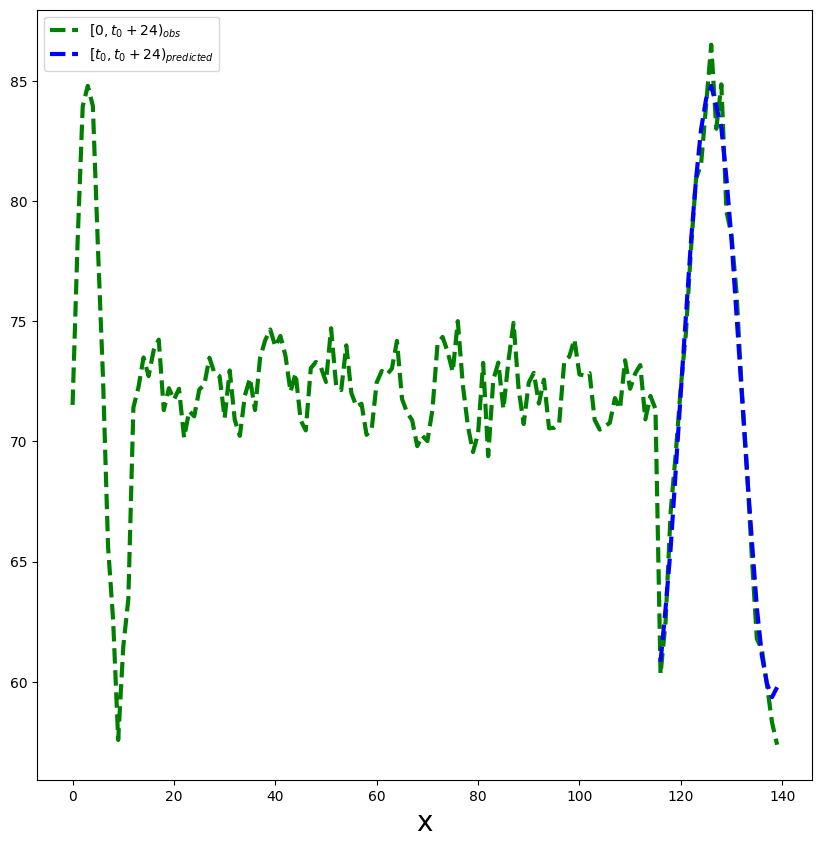

In [53]:
n_plots = 5
with torch.no_grad():
    model.eval()
    for step,(x,y,attention_masks) in enumerate(test_dl):
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())

            if step > n_plots:
                break

            with torch.no_grad():
                plt.figure(figsize=(10,10))
                plt.plot(x[0].cpu().detach().squeeze().numpy(),y[0].cpu().detach().squeeze().numpy(),'g--',linewidth=3)
                plt.plot(x[0,t0:].cpu().detach().squeeze().numpy(),output[0,(t0-1):(t0+24-1)].cpu().detach().squeeze().numpy(),'b--',linewidth=3) # not missing data
                # plt.plot(x[0,(t0-10):].cpu().detach().squeeze().numpy(),output[0,(t0-1-10):(t0+24-1-10)].cpu().detach().squeeze().numpy(),'b--',linewidth=3) # missing data
                plt.xlabel("x",fontsize=20)
                plt.legend(["$[0,t_0+24)_{obs}$","$[t_0,t_0+24)_{predicted}$"])
                plt.show()


In [54]:
def get_attn(model,x,y,attention_masks):
    model.eval()
    with torch.no_grad():
        x=x.cuda(); y=y.cuda(); attention_masks = attention_masks.cuda()
        z = torch.cat((y.unsqueeze(1),x.unsqueeze(1)),1)
        z_embedding = model.input_embedding(z).permute(2,0,1)
        positional_embeddings = model.positional_embedding(x.type(torch.long)).permute(1,0,2)
        input_embedding = z_embedding+positional_embeddings
                
        attn_layer_i = []
        for layer in model.transformer_decoder.layers:
            attn_layer_i.append(layer.self_attn(input_embedding,input_embedding,input_embedding,attn_mask=attention_masks)[-1].squeeze().cpu().detach().numpy())
            input_embedding = layer.forward(input_embedding,attention_masks)
        
        return attn_layer_i

In [55]:
idx_example = 5

In [56]:
attn_layers = get_attn(model,test_dataset[idx_example][0].unsqueeze(0),test_dataset[idx_example][1].unsqueeze(0),test_dataset[idx_example][2])

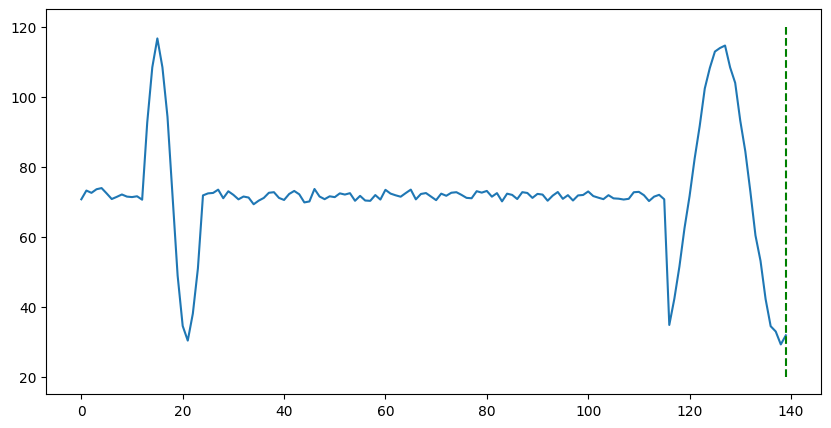

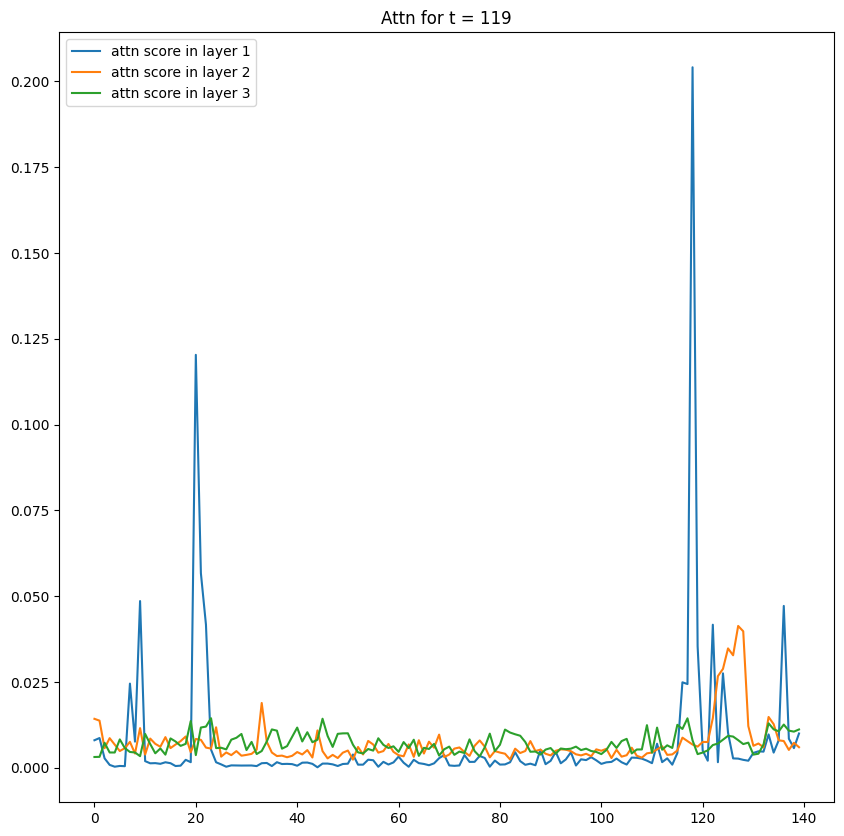

In [57]:
plt.figure(figsize=(10,5))
plt.plot(test_dataset[idx_example][0].numpy(),train_dataset[10][1].numpy())
plt.plot([t0+24-1,t0+24-1],[20,120],'g--') # not missing data
# plt.plot([t0+24-1,t0+24-1],[20,120],'g--') # missing data
plt.figure(figsize=(10,10))
plt.plot(attn_layers[0][t0+24-1]) # not missing data
plt.plot(attn_layers[1][t0+24-1]) # not missing data
plt.plot(attn_layers[2][t0+24-1]) # not missing data

#plt.plot(train_dataset[idx_example][0].numpy(),attn_layers[0][119-10]) # missing data
#plt.plot(train_dataset[idx_example][0].numpy(),attn_layers[1][119-10]) # missing data
#plt.plot(train_dataset[idx_example][0].numpy(),attn_layers[2][119-10]) # missing data



plt.legend(["attn score in layer 1","attn score in layer 2","attn score in layer 3"])
plt.title("Attn for t = 119") # not missing data

plt.show()